#  🏠 Data Mining Questions  <a id='home'></a>

Process of knowledge discovery from our dataset.

### 🛠️ [Initial Data Pull and Setup](#data_pull)

### ❓ [Data Mining Questions](#questions)
1. [Crime has steadily decreased since 2002, but plateaued in 2016.  Why might crime have plateaued?](#q1)
2. [Crime seems to be disappearing in some areas.  Which neighborhoods have gotten safer, and what might be some of the contributing factors?](#q2)
3. [Crime dropped off significantly in April of 2020.  What were the factors involved?](#q3)


# Part 1: Initial Data Pull and Setup <a id='data_pull'></a>
Links: [🏠](#home) [❓](#questions)

## 1a. Import Packages

In [1]:
# Std lib:
import warnings
import os

# To hide environment variables
from dotenv import load_dotenv

# Data manipulation:
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon

# Visualization:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('seaborn')

# Display all columns in Jupyter:
from IPython.display import display
pd.options.display.max_columns = None

# Filter Warnings
warnings.filterwarnings('ignore')

## 1b. Import Data

In [2]:
datatypes = {'block': 'object',
             'iucr': 'object',
             'primary_type': 'object',
             'description': 'object',
             'location_description': 'object',
             'arrest': 'bool',
             'domestic': 'bool',
             'beat': 'int64',
             'district': 'float64',
             'ward': 'float64',
             'community_area': 'int64',
             'fbi_code': 'object',
             'x_coordinate': 'float64',
             'y_coordinate': 'float64',
             'year': 'int64',
             'latitude': 'float64',
             'longitude': 'float64',
             'location': 'object',
             'month': 'uint8',
             'hour': 'uint8',
             'dayofweek': 'uint8',
             'weekend': 'bool',
             'CF': 'float64',
             'CF3': 'float64',
             'PI': 'float64',
             'EUH': 'float64',
             'CH': 'float64',
             'SOI': 'float64',
             'crime_code_category': 'category',
             'index_crime': 'bool',
             'violent_crime': 'bool',
             'property_crime': 'bool',
             'crime_against_persons': 'bool',
             'crime_against_property': 'bool',
             'crime_against_society': 'bool'}

In [3]:
load_dotenv()
path_to_data = os.environ.get('CLEAN_DATA')
df = pd.read_csv(path_to_data, dtype=datatypes)

<a id='home'></a>

## 1c. Miscellaneous Setup

In [53]:
single_bar_chart_params = {'edgecolor': 'black',
                           'linewidth': 1,
                           'figsize': (15, 10)}

figure_title_size = 20

# Part 2. Questions

### Question 1: Crime has steadily decreased since 2002, but plateaued in 2016. Why might crime have plateaued?

In [20]:
q1_df = df[df.year.isin(list(range(2002, 2020)))]

#### Visualizing the trend in frequency of crime in Chicago

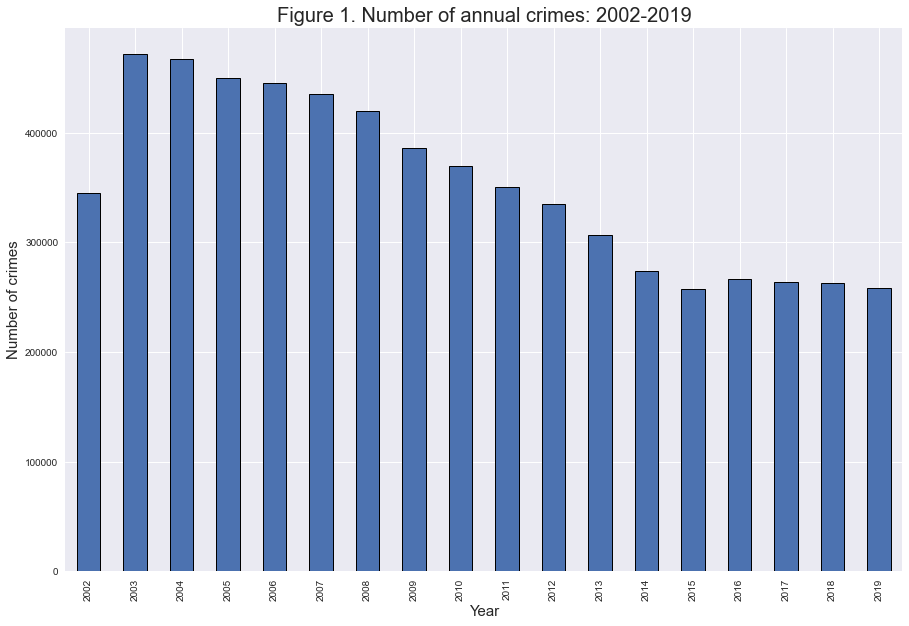

In [54]:
# Figure 1.

# Data:
num_crimes_by_year = q1_df.groupby('year').size()

# Plotting:
figure1_title = 'Figure 1. Number of annual crimes: 2002-2019'
figure1_ylabel = 'Number of crimes'
figure1_xlabel = 'Year'

figure1 = num_crimes_by_year.plot.bar(**single_bar_chart_params)
figure1.set_title(figure1_title, fontsize=figure_title_size)
figure1.set_ylabel(figure1_ylabel, fontsize=15)
figure1.set_xlabel(figure1_xlabel, fontsize=15);

Figure 1: The number of annual crimes in Chicago saw a steady decrease over the years 2003-2015, then plateaued after 2015. 

One way to gain insight into this question is to see if crime uniformly plateaued (all individual types of crime followed the same pattern as total crime) or if we had a specific spike in one type of crime and reduction in another.

#### Break this out by crime type

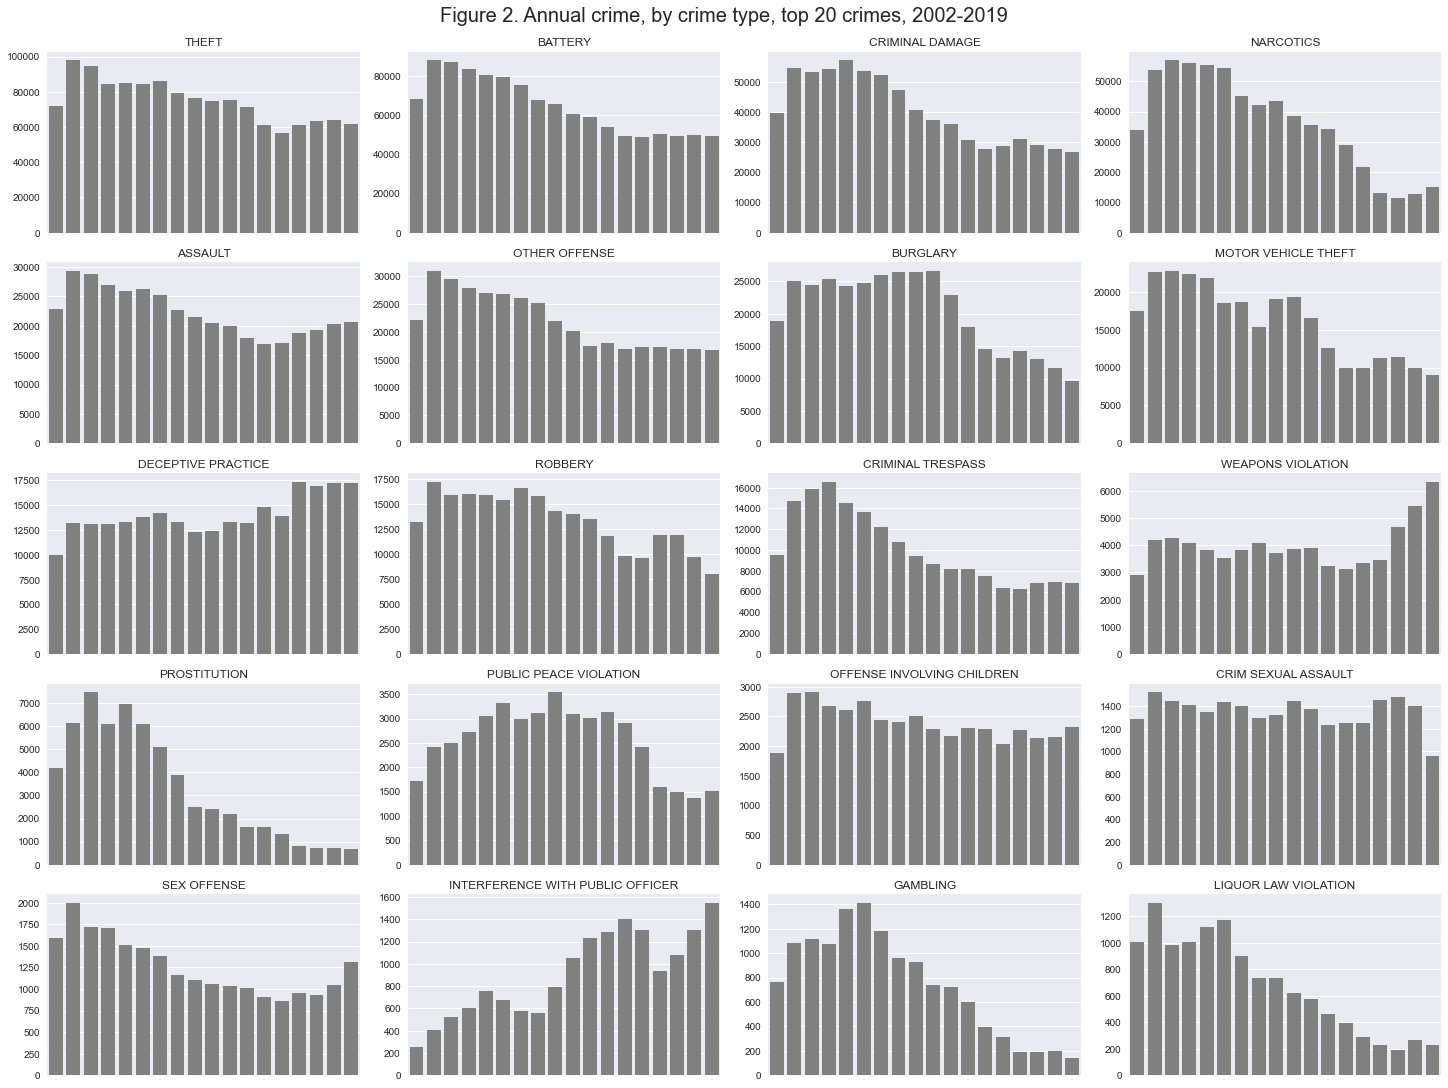

In [57]:
# Figure 2.

n = 20
top_n_crimes = q1_df.groupby('primary_type').size().sort_values(ascending=False)[:n].index.to_list()

# Plotting Specifications:
figure2_title = 'Figure 2. Annual crime, by crime type, top 20 crimes, 2002-2019'

figure2_params = {'figsize': (20, 15),
                  'constrained_layout': True}
rows=5
cols=4

assert rows * cols == n, f'You are attempting to plot {n} crimes but only made room for {rows * columns} subplots.  Ensure n = rows * columns'

figure2, axes = plt.subplots(rows, cols, **figure2_params)
figure2.suptitle(figure2_title, fontsize=figure_title_size)
axes = axes.flatten()

for idx, crime in enumerate(top_n_crimes):
    crimeX_by_year = q1_df[q1_df.primary_type == crime].groupby('year').size()
    crimeX_by_year_plot = sns.barplot(ax=axes[idx], x=crimeX_by_year.index, y=crimeX_by_year.values, color='gray')
    axes[idx].set_title(crime)
    crimeX_by_year_plot.set(xlabel=None)
    crimeX_by_year_plot.set(xticklabels=[]) # Remove x labels (we are only looking at trends)

Figure 2. Looking at the trends in the top 20 crimes, it looks like almost all either plateaued in 2016-2019, with some that increased.  Keeping in mind that these crimes are ordered by frequency, the earlier plots have greater weight.

#### Using linear regression to examine each crime's trends during the "decline years" vs. the "plateau years". We will compare the years 2012-2015 with the years 2016-2019.

In [60]:
from scipy.stats import linregress

def get_slope(df, date_range, crime=None):
    truncated_df = df[df.year.isin(date_range)]
    # If no crime is specified, then we will find
    # the slope of total crime over the date range.
    if not crime:
        number_of_crimes_per_year = truncated_df.groupby('year').size()
    else:
        number_of_crimes_per_year = truncated_df[truncated_df.primary_type == crime].groupby('year').size()
    
    x = date_range
    y = np.array(number_of_crimes_per_year)

    return linregress(x, y).slope

#### 2012-2015: The decline years

In [65]:
time_domain = [2012, 2013, 2014, 2015]

trends_decline = [(crime, get_slope(q1_df, time_domain, crime)) for crime in top_n_crimes]
trends_decline.sort(key=lambda x: x[1], reverse=True)
trends_decline.append(('Total', get_slope(q1_df, time_domain)))

In [89]:
d = {'CrimeType': [x[0] for x in trends_decline], 'AvgAnnualChangeDecline': [x[1] for x in trends_decline]}
df_trends_2012_2015 = pd.DataFrame(data=d)
df_trends_2012_2015

,CrimeType,AvgAnnualChangeDecline
0,DECEPTIVE PRACTICE,364.9
1,INTERFERENCE WITH PUBLIC OFFICER,34.8
2,CRIM SEXUAL ASSAULT,-37.5
3,OFFENSE INVOLVING CHILDREN,-41.0
4,SEX OFFENSE,-60.4
5,LIQUOR LAW VIOLATION,-91.6
6,GAMBLING,-144.5
7,OTHER OFFENSE,-162.1
8,WEAPONS VIOLATION,-185.0
9,PUBLIC PEACE VIOLATION,-201.3


Table 1. Over the "decline years", the average annual change for most crimes was negative.

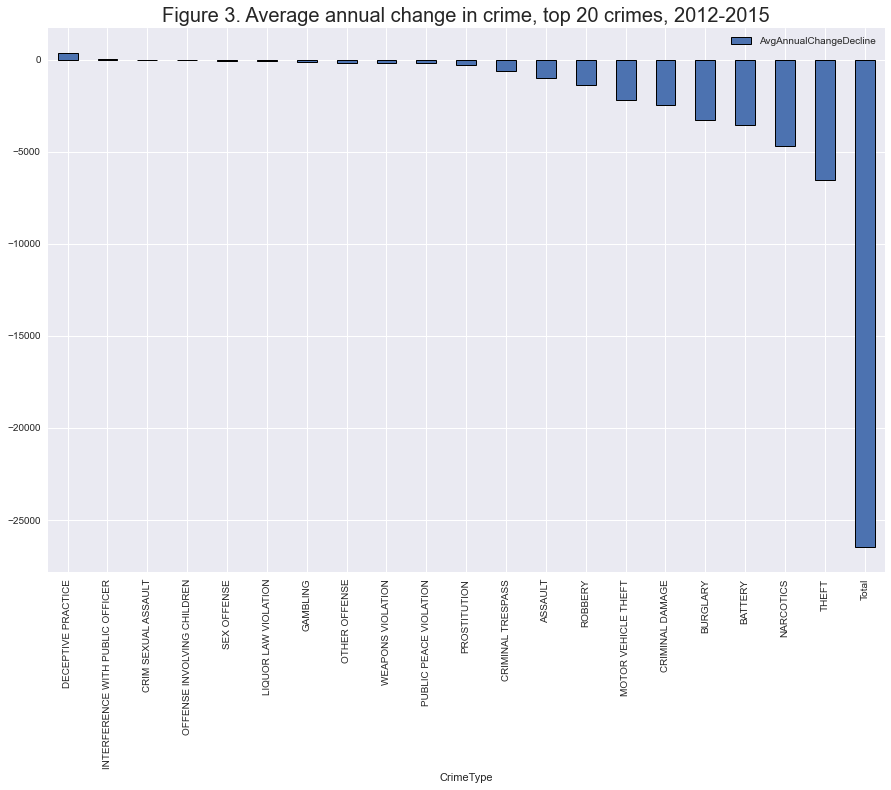

In [90]:
figure3_title = 'Figure 3. Average annual change in crime, top 20 crimes, 2012-2015'

figure3 = df_trends_2012_2015.plot.bar(x='CrimeType', y='AvgAnnualChangeDecline', **single_bar_chart_params);
figure3.set_title(figure3_title, fontsize=figure_title_size);

#### 2016-2019: The plateau years

In [75]:
time_domain = [2016, 2017, 2018, 2019]

trends_plateau = [(crime, get_slope(q1_df, time_domain, crime)) for crime in top_n_crimes]
trends_plateau.sort(key=lambda x: x[1], reverse=True)
trends_plateau.append(('Total', get_slope(q1_df, time_domain)))

In [91]:
d2 = {'CrimeType': [x[0] for x in trends_plateau], 'AvgAnnualChangePlateau': [x[1] for x in trends_plateau]}
df_trends_2016_2019 = pd.DataFrame(data=d2)
df_trends_2016_2019

,CrimeType,AvgAnnualChangePlateau
0,WEAPONS VIOLATION,942.6
1,ASSAULT,673.2
2,NARCOTICS,653.8
3,THEFT,235.6
4,INTERFERENCE WITH PUBLIC OFFICER,205.5
5,CRIMINAL TRESPASS,161.2
6,SEX OFFENSE,120.1
7,OFFENSE INVOLVING CHILDREN,13.1
8,LIQUOR LAW VIOLATION,8.9
9,DECEPTIVE PRACTICE,-9.8


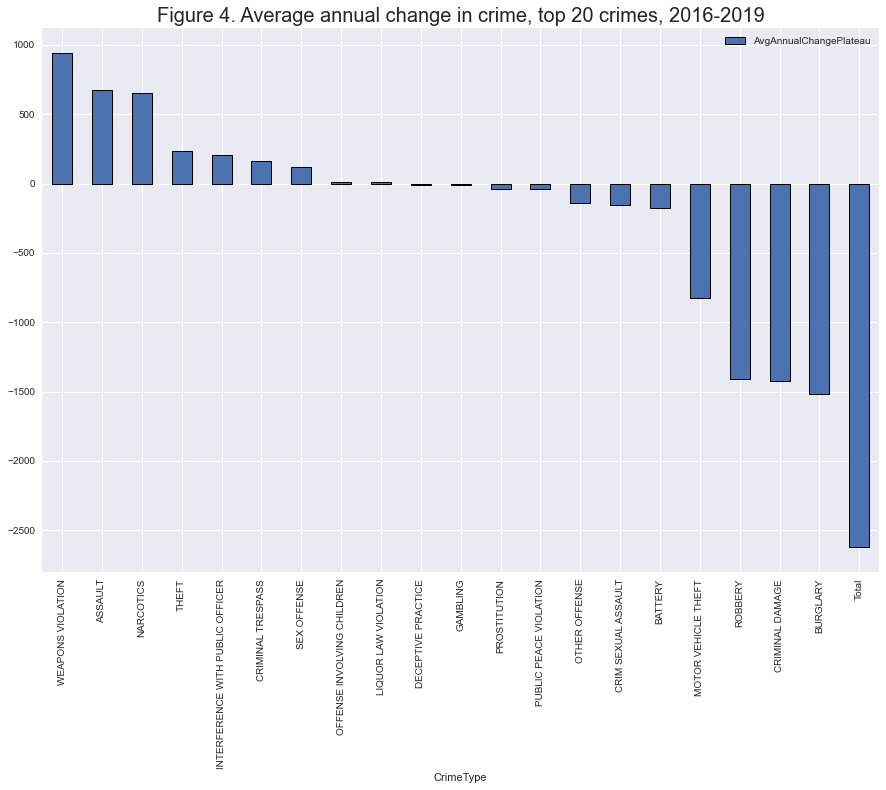

In [92]:
figure4_title = 'Figure 4. Average annual change in crime, top 20 crimes, 2016-2019'

figure4 = df_trends_2016_2019.plot.bar(x='CrimeType', y='AvgAnnualChangePlateau', **single_bar_chart_params);
figure4.set_title(figure4_title, fontsize=figure_title_size);

Let's compare the two periods in a visualization

In [95]:
trend_df = df_trends_2012_2015.join(df_trends_2016_2019.set_index('CrimeType'), on='CrimeType').set_index('CrimeType')
trend_df

,AvgAnnualChangeDecline,AvgAnnualChangePlateau
CrimeType,,
DECEPTIVE PRACTICE,364.9,-9.8
INTERFERENCE WITH PUBLIC OFFICER,34.8,205.5
CRIM SEXUAL ASSAULT,-37.5,-157.8
OFFENSE INVOLVING CHILDREN,-41.0,13.1
SEX OFFENSE,-60.4,120.1
LIQUOR LAW VIOLATION,-91.6,8.9
GAMBLING,-144.5,-13.1
OTHER OFFENSE,-162.1,-143.6
WEAPONS VIOLATION,-185.0,942.6


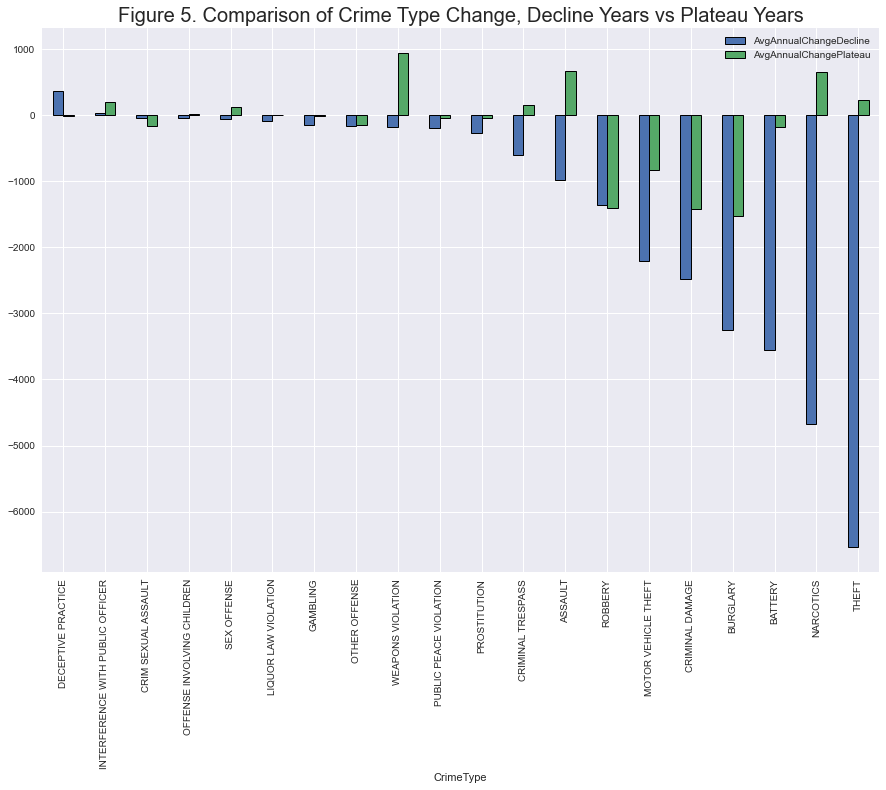

In [101]:
figure5_title = 'Figure 5. Comparison of Crime Type Change, Decline Years vs Plateau Years'

figure5 = trend_df[trend_df.index != 'Total'].plot.bar(**single_bar_chart_params)
figure5.set_title(figure5_title, fontsize=figure_title_size);

Our conclusion: the plateau in crime was driven by certain frequent crimes no longer decreasing (theft, narcotics), but rather increasing!

### Question 2: Crime seems to be disappearing in some areas.  Which neighborhoods have gotten safer, and what might be some of the contributing factors? 

In [103]:
# TODO: q2

### Quesion 3: Crime dropped off significantly in April of 2020.  What were the factors involved?

In [107]:
econ_df_full = pd.DataFrame(df.groupby(['year', 'month'])['CF', 'PI', 'EUH', 'CH', 'SOI'].mean()).reset_index()
econ_df_full['date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(econ_df_full.year, econ_df_full.month)])
total_crime_df_full = pd.DataFrame(df.groupby(['year', 'month']).size()).reset_index()  # Total crime per month
total_crime_df_full.columns = ['year', 'month', 'total_crime']  # Rename the columns
total_crime_plus_econ_df_full = pd.merge(econ_df_full, total_crime_df_full)

In [138]:
temp5 = pd.DataFrame({'Date': df.date, 'Year': df.year, 'Month': df.month, 'CF': df.CF})
temp5.groupby(['Year', 'Month']).count()

Date     CF
Year Month              
2001 1        405    405
     2        166    166
     3        193    193
     4        245    245
     5        228    228
...           ...    ...
2020 4      12548  12548
     5      17160  17160
     6      17222  17222
     7      19073  19073
     8      19279  19279

[236 rows x 2 columns]

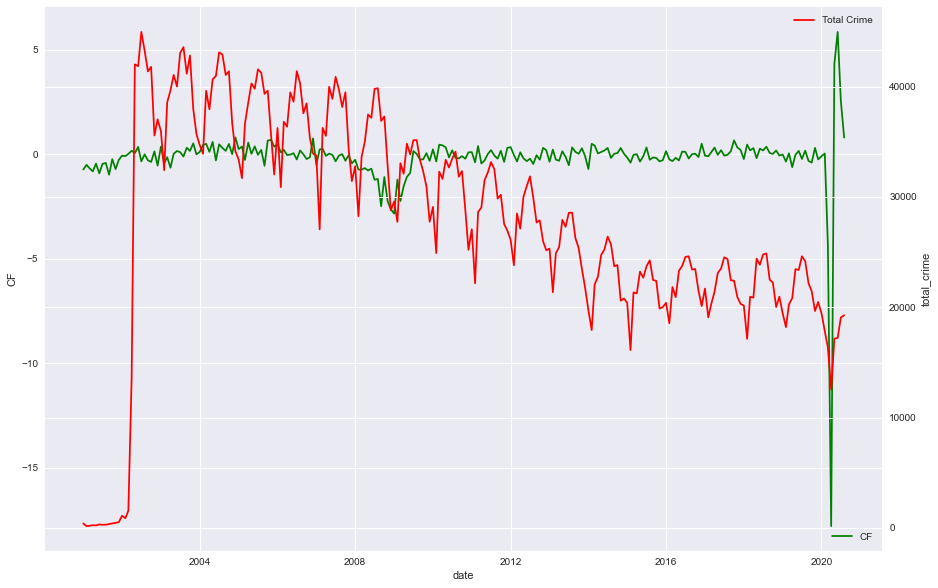

In [113]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.lineplot(x="date", y="CF", data=total_crime_plus_econ_df_full, ax=ax, color='green', label='CF');
ax.legend(loc='lower right')
ax2 = ax.twinx()
sns.lineplot(x="date", y="total_crime", data=total_crime_plus_econ_df_full, ax=ax2, color='red', label='Total Crime');
plt.show()

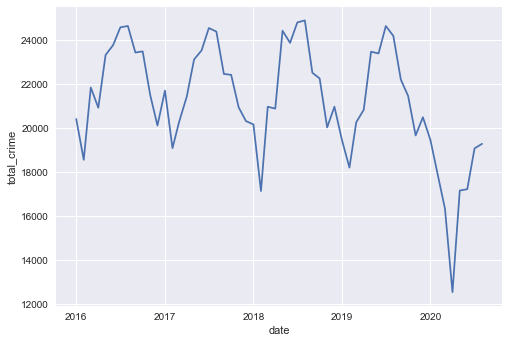

In [114]:
last_5 = [2016, 2017, 2018, 2019, 2020]
temp1 = total_crime_plus_econ_df_full.loc[total_crime_plus_econ_df_full['year'].isin(last_5)]

sns.lineplot(x="date", y="total_crime", data=temp1);

In [116]:
aprils_df = df[(df.month == 4)]

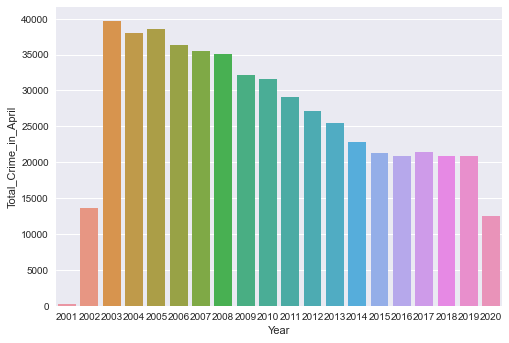

In [117]:
april_year_over_year = pd.DataFrame(aprils_df.groupby('year').size()).reset_index()
april_year_over_year.columns = ['Year', 'Total_Crime_in_April']
sns.barplot(x='Year', y='Total_Crime_in_April', data=april_year_over_year);

In [118]:
april_year_type_df = pd.DataFrame(aprils_df.groupby(['year', 'primary_type']).size()).reset_index()
last_3 = [2018, 2019, 2020]
temp2 = april_year_type_df.loc[april_year_type_df['year'].isin(last_3)]
temp2.columns = ['year', 'primary_type', 'count']
t_2020 = temp2[temp2.year == 2020]
t_2020.columns = ['year', 'primary_type', '2020_count']
t_2019 = temp2[temp2.year == 2019]
t_2019.columns = ['year', 'primary_type', '2019_count']
t_2018 = temp2[temp2.year == 2018]
t_2018.columns = ['year', 'primary_type', '2018_count']
temp2 = pd.merge(t_2019, t_2020, on="primary_type")
temp2 = pd.merge(temp2, t_2018)
temp2.drop(['year_x', 'year_y', 'year'], inplace=True, axis=1)
temp2['2019_percent'] = (temp2['2019_count'] / temp2['2019_count'].sum() * 100)
temp2['2020_percent'] = (temp2['2020_count'] / temp2['2020_count'].sum() * 100)
temp2['2018_percent'] = (temp2['2018_count'] / temp2['2018_count'].sum() * 100)
temp2['diff_2019_2020'] = temp2['2020_percent'] - temp2['2019_percent']
temp2['diff_2018_2019'] = temp2['2019_percent'] - temp2['2018_percent']
temp2=temp2.reindex(columns=['primary_type', '2018_count', '2019_count', '2020_count', '2018_percent', 'diff_2018_2019', '2019_percent', 'diff_2019_2020', '2020_percent'])

In [119]:
temp2

,primary_type,2018_count,2019_count,2020_count,2018_percent,diff_2018_2019,2019_percent,diff_2019_2020,2020_percent
0,ARSON,27,31,35,0.130083,0.019408,0.149491,0.129438,0.278929
1,ASSAULT,1639,1732,1109,7.896512,0.455709,8.352221,0.485841,8.838062
2,BATTERY,3798,3974,2689,18.298323,0.865490,19.163813,2.265896,21.429710
3,BURGLARY,942,700,519,4.538447,-1.162838,3.375609,0.760508,4.136117
4,CONCEALED CARRY LICENSE VIOLATION,11,20,7,0.052997,0.043449,0.096446,-0.040660,0.055786
5,CRIMINAL DAMAGE,2235,2276,1772,10.767971,0.207580,10.975551,3.146221,14.121772
6,CRIMINAL SEXUAL ASSAULT,9,37,57,0.043361,0.135064,0.178425,0.275831,0.454256
7,CRIMINAL TRESPASS,585,562,235,2.818462,-0.108330,2.710132,-0.837323,1.872808
8,DECEPTIVE PRACTICE,1447,1419,897,6.971478,-0.128637,6.842841,0.305708,7.148550
9,HOMICIDE,43,60,62,0.207169,0.082169,0.289338,0.204765,0.494103
